# Desafío 03

## Integrantes

- Acevedo Zain, Gaspar (acevedo.zain.gaspar@gmail.com)

## Consignas

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


***Sugerencias***
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Imports

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
import urllib.request
import bs4 as bs

In [3]:
from tensorflow.keras.utils import pad_sequences

In [4]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from scipy.special import softmax

## Selección del corpus

El objetivo de esta práctica es evaluar modelos de lenguajes con *tokenización por caracteres*, por lo cual, un texto lo suficientemente grande puede servir como `Corpus`.

Se elige entonces el libro `La Metamorfosis` de Franz Kafka
 ([source](https://www.textos.info/homero/odisea/ebook)) como `Corpus`.

In [7]:
# libro_url = "https://www.textos.info/homero/odisea/ebook"
libro_url = "https://www.textos.info/franz-kafka/la-metamorfosis/ebook"
# libro_url = "https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook"
# libro_url = "https://www.textos.info/nicolas-maquiavelo/el-principe/ebook"
# libro_url = "https://www.textos.info/jane-austen/orgullo-y-prejuicio/ebook"

In [8]:
raw_html = urllib.request.urlopen(libro_url).read()

Se procesa el *html* original mediante la utilidad `bs.BeautifulSoup` a fin de tener el texto en ***un solo string***.

In [9]:
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

article_text = article_text.lower()

Se muestran los primeros $500$ caracteres del texto (corpus).

In [10]:
article_text[:500]

' cuando gregorio samsa se despertó una mañana después de un sueño \nintranquilo, se encontró sobre su cama convertido en un monstruoso \ninsecto. estaba tumbado sobre su espalda dura, y en forma de caparazón \ny, al levantar un poco la cabeza veía un vientre abombado, parduzco, \ndividido por partes duras en forma de arco, sobre cuya protuberancia \napenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. \nsus muchas patas, ridículamente pequeñas en comparación con el resto de \nsu tamaño'

En el texto se observan algunas *secuencias de escape de caracteres* (salto de línea o `\n`), por lo cual se las reemplaza a continuación con un caracter vacío.

In [11]:
article_text = str.replace(article_text, "\n", "")

In [12]:
article_text[:500]

' cuando gregorio samsa se despertó una mañana después de un sueño intranquilo, se encontró sobre su cama convertido en un monstruoso insecto. estaba tumbado sobre su espalda dura, y en forma de caparazón y, al levantar un poco la cabeza veía un vientre abombado, parduzco, dividido por partes duras en forma de arco, sobre cuya protuberancia apenas podía mantenerse el cobertor, a punto ya de resbalar al suelo. sus muchas patas, ridículamente pequeñas en comparación con el resto de su tamaño, le vi'

## Definición del vocabulario + Tokenización

En esta sección definiremos nuestro `vocabulario` a partir del corpus original.

Luego lo tokenizaremos, a fin de que pueda ser procesado por una Red Neuronal en pasos posteriores.

Comenzamos definiendo nuestro vocabulario, que es el conjunto de distintos caracteres que aparecen en nuestro corpus.

Para el caso particular del texto seleccionado el tamaño es de $59$.

Este valor lo guardamos en la variable `VOCAB_SIZE`.

In [13]:
char_vocab = set(article_text)
VOCAB_SIZE = len(char_vocab)
print(f"Tamaño del vocabulario: {VOCAB_SIZE}")

Tamaño del vocabulario: 59


Definimos dos diccionarios que se utilizarán a lo largo de este trabajo:
- `char2idx`: A cada caracter de nuestro vocabulario se le asigna un `índice`.
- `idx2char`: Es el *inverso* de `char2idx`, es decir, dado un índice, me devuelve el caracter correspondiente.

In [14]:
char2idx = {k: v for v,k in enumerate(char_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

Ahora `tokenizamos` el corpus. Para ello hacemos uso del diccionario `char2idx`, reemplazando cada caracter por su índice correspondiente.

In [15]:
tokenized_text = [char2idx[ch] for ch in article_text]

## Definición del dataset

En esta sección definimos los datos de entrenamiento y validación.

Primero se definien las siguientes constantes:
- `MAX_CONTEXT_SIZE`: corresponde al tamaño máximo del contexto que se analizará. Se define inicialmente en $100$.
- `P_VAL`: tamaño del set de validación. En este caso, se opta por utilizar el $10\%$.

In [16]:
MAX_CONTEXT_SIZE = 100
P_VAL = 0.1

Se define también la cantidad de secuencias de tamaño `MAX_CONTENT_SIZE` que tendrá el set de validación mediante la variable `NUM_VAL`.

Dado a que el tamaño del texto tokenizado es $121432$, el valor de `NUM_VAL` queda en $122$, es decir, habrá en el set de validación un total de $122$ secuencias de tamaño máximo $100$.

In [17]:
NUM_VAL = int(np.ceil(len(tokenized_text)*P_VAL/MAX_CONTEXT_SIZE))

In [18]:
NUM_VAL, len(tokenized_text)

(122, 121432)

Se realiza la separación del corpus original en `train` (train_text) y `validation` (val_text).

In [19]:
train_text = tokenized_text[:-NUM_VAL * MAX_CONTEXT_SIZE]
val_text = tokenized_text[-NUM_VAL * MAX_CONTEXT_SIZE:]

In [20]:
tokenized_sentences_val = [val_text[init*MAX_CONTEXT_SIZE:init*(MAX_CONTEXT_SIZE+1)] for init in range(NUM_VAL)]
tokenized_sentences_train = [train_text[init:init+MAX_CONTEXT_SIZE] for init in range(len(train_text)-MAX_CONTEXT_SIZE+1)]

In [21]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Validamos los tamaños de `X` e `y`.

In [22]:
X.shape

(109132, 100)

In [23]:
y.shape

(109132, 100)

In [24]:
VOCAB_SIZE = len(char_vocab)

## Funciones útiles

En esta sección se definen una serie de funciones que se utilizarán a lo largo del entrenamiento de los distintos modelos a estudiar.

La función `PplCallback` fue tomada de las notebooks provistas por la materia (Fuente: [Clase 4 - 4_modelo_lenguaje_char.ipynb](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb)).

La misma permite calcular la métrica de `Perplejidad` al final de cada *epoch* de *entrenamiento*.

Se caracteriza además por implementar `Early Stopping` en caso de que la métrica de perplejidad **NO** mejore luego de una cantidad definida de epochs (`patience`, con valore por defecto $5$).

También se encarga de guardar el *historial* del perplexity en cada epoch, a fin de poder analizar posteriormente.

In [25]:
class PplCallback(keras.callbacks.Callback):
    '''
    - Callback ad-hoc para calcular al final de cada epoch de entrenamiento
      la métrica de Perplejidad sobre un conjunto de datos de validación.
    - Implementa Early Stopping si la perplejidad no mejora después de
      `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      self.val_data = val_data

      self.target = []
      self.padded = []
      self.history_ppl = history_ppl

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      for seq in self.val_data:

        len_seq = len(seq)

        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:
          self.padded.append(pad_sequences(subseq, maxlen=MAX_CONTEXT_SIZE, padding='pre'))
          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        # Perplejidad de cada secuencia
        scores = []
        predictions = self.model.predict(self.padded,verbose=0)

        for start, end in self.info:
          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # Early Stopping
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


Las siguientes funciones permiten hacer un `encode` y un `decode` de una secuencia dada.

Fueron tomadas también de las notebooks provistas por la materia. (Fuente: [Clase 4 - 4_modelo_lenguaje_char.ipynb](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb)).

In [26]:
def encode(text, max_length=MAX_CONTEXT_SIZE):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

La función `generate_seq` permite, dado un modelo entrenado, generar una secuencia de caracteres mediante `Greedy` Search. Es decir, funciona de manera autoregresiva.

Fue tomada también de las notebooks provistas por la materia. (Fuente: [Clase 4 - 4_modelo_lenguaje_char.ipynb](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb)).

In [27]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

Las siguientes funciones serán utilizadas al estudiar `BEAM` search.

Fueron tomadas también de las notebooks provistas por la materia. (Fuente: [Clase 4 - 4_modelo_lenguaje_char.ipynb](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb)).

In [28]:
def select_candidates(pred, num_beams, vocab_size, history_probs,
                      history_tokens, temp,mode):
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    # beam search determinista
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    # beam search con muestreo aleatorio
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams,
                                  p=softmax(pred_large/temp))
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

In [29]:
def beam_search(model, num_beams, num_words, input, temp=1, mode='det'):
    encoded = encode(input)
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]
    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):
      preds = []
      for hist in history_tokens:
        input_update = np.array([hist[i+1:]]).copy()
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]
        preds.append(y_hat)
      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

## Modelo Simple RNN

### Definición del modelo

El primer modelo a estudiar está basado en el modelo propuesto en al Notebook [4_modelo_lenguaje_char.ipynb](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_4/ejercicios/4_modelo_lenguaje_char.ipynb) de la `Clase 4`.

Consta de un modelo secuencial compuesto por las siguientes capas:
1. Transforma los índices de los tokens en vectores de `One Hot Encoding`, utilizando **TimeDistributed** y **CategoryEncoding**.
1. Implementa una capa de `SimpleRNN` (celda de Elman), la cual implementa **Dropout** y **Recurrent Dropout** de $0.1$.
1. Capa `fully connected` implementada mediante **Dense**, con tamaño igual a `VOCAB_SIZE` ($59$) y función de activación **softmax**.

Otros detalles del modelo:
- El optimizador utilizado es `rmsprop`.
- La función de pérdida utilizada es `sparse_categorical_crossentropy`.

In [30]:
simpleRNN = Sequential()

simpleRNN.add(TimeDistributed(CategoryEncoding(num_tokens=VOCAB_SIZE, output_mode = "one_hot"),input_shape=(None,1)))
simpleRNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
simpleRNN.add(Dense(VOCAB_SIZE, activation='softmax'))
simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

simpleRNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 59)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        52,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 59)       │        11,859 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,859 (249.45 KB)

 Trainable params: 63,859 (249.45 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [31]:
CANT_EPOCHS = 50

A continuación se entrena al modelo, utilizando $50$ épocas y un `batch_size` de $256$.

In [32]:
simpleRNN_perplexity_history = []
simpleRNN_history = simpleRNN.fit(X, y, epochs=CANT_EPOCHS, callbacks=[PplCallback(tokenized_sentences_val, simpleRNN_perplexity_history)], batch_size=256)

Epoch 1/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5891
 mean perplexity: 8.213508252302805 

Saved new model!
427/427 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - loss: 2.5884
Epoch 2/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9990
 mean perplexity: 7.4377796292305 

Saved new model!
427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.9988
Epoch 3/50
425/427 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8488
 mean perplexity: 6.826892785231272 

Saved new model!
427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.8486
Epoch 4/50
424/427 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7473
 mean perplexity: 6.6013203918933865 

Saved new model!
427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.7471
Epoch 5/50
425/427 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6797
 mean perplexity: 6.435647811492284 

Saved new model!
427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.6796
Epoch 6/50
425/427 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6339
 mean perplexity: 6.379971164464

### Gráfico de perplejidad

Se observa que el modelo fue entrenado durante $17$ épocas, ya que se llegó a una etapa de `Early Stopping` al no haber mejora de la métrica de `Perplexity` en un patience de $5$ épocas.

Se grafica a continuación la evolución de la perplejidad por época.

Se observa que la misma disminuye a medida que se avanza en los EPOCHS. Esto quiere decir que el modelo está mejorando la certeza que tiene sobre sus predicciones.

La perplejidad mínima obtenida fue en el EPOCH $12$, con un valor de $6.14$.

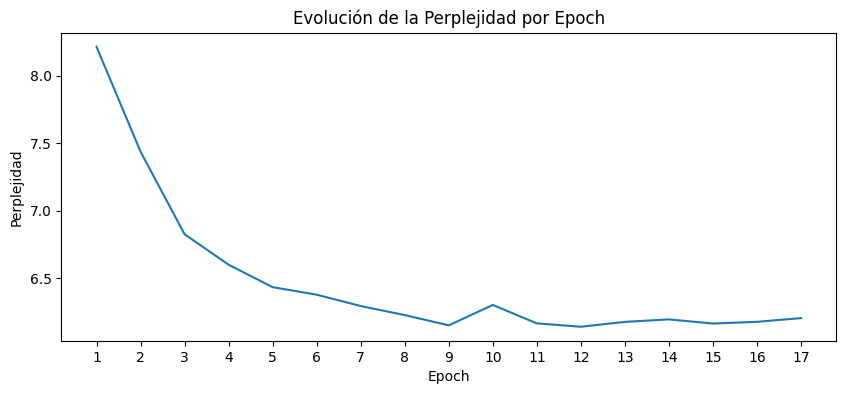

In [55]:
epoch_count = range(1, len(simpleRNN_perplexity_history) + 1)

plt.figure(figsize=(10, 4))
sns.lineplot(x=epoch_count, y=simpleRNN_perplexity_history)
plt.xlabel("Epoch")
plt.ylabel("Perplejidad")
plt.title("Evolución de la Perplejidad por Epoch")
plt.xticks(epoch_count)
plt.show()

In [54]:
min_perplexity = min(simpleRNN_perplexity_history)
min_idx = simpleRNN_perplexity_history.index(min_perplexity)

print(f"La Perplejidad mínima alcanzada fue {min_perplexity} y se logró en el EPOCH {min_idx + 1}")

La Perplejidad mínima alcanzada fue 6.143005148569743 y se logró en el EPOCH 12


### Generación de Texto con Greedy Search

Comenzamos cargando el mejor modelo que se obtuvo durante el entrenamiento.

In [45]:
simpleRNN_model = keras.models.load_model("my_model.keras")

Mediante la función `generate_seq` (ver sección de `Funciones útiles`) generamos texto mediante ***Greedy*** search.

En este caso, indicamos que se genere texto a partir del *input* `Grego` (por Gregorio, el nombre del protagonista del libro), con un *MAX_CONTEXT_SIZE* de $100$ y que la cantidad de texto a generar tenga $120$ caracteres totales.

In [73]:
generate_seq(simpleRNN_model, "Grego", MAX_CONTEXT_SIZE, 120)

'Gregorio se había apresurado en el canapé, por el canapé, por el canapé, por el canapé, por el canapé, por el canapé, por el '

Se observa que el resultado es poco coherente, ya que, si bien el comienzo de la frase generada tiene sentido, se *repite* varias veces el texto ***por el canapé***.

Como detalle, la frase `Gregorio se había apresurado` aparece una sola vez en el libro, más precisamente:

> ***Gregorio se había apresurado*** a colocar la sábana aún más bajo y con más pliegues, de modo que, de verdad, tenía el aspecto de una sábana lanzada casualmente sobre ***el canapé***.

### Generación de Texto con Beam Search

In [ ]:
simpleRNN_model = keras.models.load_model("my_model.keras")

Para generar texto mediante ***Beam*** search utilizaremos la función `beam_search` (ver sección de `Funciones útiles).

Se utilizarán los siguientes parámetros:
- Input: `grego`.
- Cantidad de **Beams**: $10$.
- Tamaño de salida: $120$ caracteres.
- Temperaturas: $0.75$, $1.0$, $1.5$ y $2.0$.

Se explorarán los modos `Determinístico` y `Estocástico`.

In [76]:
NUM_WORDS = 120
NUM_BEAMS = 10
INPUT = "grego"
TEMPERATURES = [0.75, 1.0, 1.5, 2.0]
MODO_DETERMINISTA = "det"
MODO_ESTOCASTICO = "sto"

***Modo Determinista***

Se muestan a continuación el resultado del modo `Determinista`:

In [79]:
resultado = beam_search(model=simpleRNN_model, num_beams=NUM_BEAMS, num_words=NUM_WORDS, input=INPUT, temp=1.0, mode=MODO_DETERMINISTA)
resultado_decoded = decode(resultado[0])
print(f"Beam Search - Modo DETERMINISTA:\n\t{resultado_decoded}\n")

Beam Search - Modo DETERMINISTA:
	gregorio se encontraba en la habitación de la habitación de la habitación de la habitación de la habitación de la habitación 



Se observa que el resultado del modo determinista tiene poca coherencia, además de que repite varias veces una secuencia específica de caracteres.

***Modo Estocástico***

Se muestan a continuación los resultados del modo `Estocástico`:

In [78]:
for temp in TEMPERATURES:
  resultado = beam_search(model=simpleRNN_model, num_beams=NUM_BEAMS, num_words=NUM_WORDS, input=INPUT, temp=temp, mode=MODO_ESTOCASTICO)
  resultado_decoded = decode(resultado[0])
  print(f"Beam Search - Modo ESTOCASTICO - Temperatura {temp}:\n\t{resultado_decoded}\n")

Beam Search - Modo ESTOCASTICO - Temperatura 0.75:
	gregorio había apoderado en el apoderado en la habitación de gregorio se había estado en la habitación de gregorio se había u

Beam Search - Modo ESTOCASTICO - Temperatura 1.0:
	gregorio se había estado en la habitación de gregorio había la habitación de gregorio se había apoderado en la habitación de 

Beam Search - Modo ESTOCASTICO - Temperatura 1.5:
	gregorio para estaba en la habitación en la habitación de gregorio se había en su habitación de gregorio se padre para sus pa

Beam Search - Modo ESTOCASTICO - Temperatura 2.0:
	gregorio hacía en el cuerto, no había dos considera en el padre sobre el podre sobre las decidido había ahora, en su habitaci



Se observa que los resultados del modo estocástico carecen de sentido, independientemente de la *temperatura* utilizada.